In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
np.random.seed(42)

# Function to generate the dataset for linear regression
def generate_linear_regression_dataset(n_samples, n_features, noise_std):
    # Draw covariates from a Gaussian distribution
    X = np.random.normal(0, 1, (n_samples, n_features))

    # Define the true parameter vector 𝜃* (all ones)
    theta_star = np.ones(n_features)

    # Draw noise from a Gaussian distribution
    noise = np.random.normal(0, noise_std, n_samples)

    # Compute the response variable Y
    Y = X @ theta_star + noise

    return X, Y

# Gradient of the squared error loss function for linear regression
def gradient_squared_error_loss(theta, X, Y):
    if X.ndim == 1:
        X = X.reshape(1, -1)
    return -X.T @ (Y - X @ theta)

# Generate weights from a uniform distribution
def generate_weights(n_samples, gamma, sigma):
    p = np.random.uniform(size=n_samples)
    #p = np.random.binomial(n=1, p=0.5, size=n_samples)
    
    def weight_form(alpha):
        return (p**alpha)/(p**alpha + (1-p)**alpha)**(1/alpha)
    
    #gamma = 0.3
    #sigma = 0.1
    w = weight_form(gamma) + weight_form(sigma)
    return w

# Update the model parameters 𝜃 using the given update rule
def update_theta(theta, X, Y, learning_rate, flag, gamma=0.5, sigma=0.5):
    n_samples = X.shape[0]
    
    if flag==0:
        weights = np.ones(n_samples)
    else:
        weights = generate_weights(n_samples, gamma, sigma)
        #print(weights.mean())
    weighted_gradients = np.zeros_like(theta)
    
    for i in range(n_samples):
        gradient = gradient_squared_error_loss(theta, X[i], Y[i])
        weighted_gradients += weights[i] * gradient
        
    theta_next = theta - learning_rate / n_samples * weighted_gradients
    return theta_next

# Mean Squared error loss function for linear regression
def ERM_loss(theta, X, Y):
    n_samples = X.shape[0]
    return 0.5 * np.sum((Y - X @ theta)**2) / n_samples

# Mean Squared error loss function for linear regression
def HRM_loss(theta, X, Y, gamma, sigma):
    n_samples = X.shape[0]
    weights = generate_weights(n_samples, gamma, sigma)
    return 0.5 * np.sum(weights * (Y - X @ theta)**2) / n_samples

# Iterative optimization procedure for the empirical minimizer of different L-Risks
def optimize_theta(X, Y, learning_rate, n_iterations, flag=0, gamma=0.5, sigma=0.5):
    n_features = X.shape[1]
    theta = np.zeros(n_features)
    loss_history = []
    n_samples = X.shape[0]

    for t in range(n_iterations):
        theta = update_theta(theta, X, Y, learning_rate, flag, gamma, sigma)

        if flag == 0:
            loss = ERM_loss(theta, X, Y)
        else:
            loss = HRM_loss(theta, X, Y, gamma, sigma)

        loss_history.append(loss)

    return theta, loss_history

# Generate the entire dataset
n_samples = 20000
n_features = 5
noise_std = 0.1
X, Y = generate_linear_regression_dataset(n_samples, n_features, noise_std)

# Parameters for the optimization
learning_rate = 0.1
n_iterations = 200

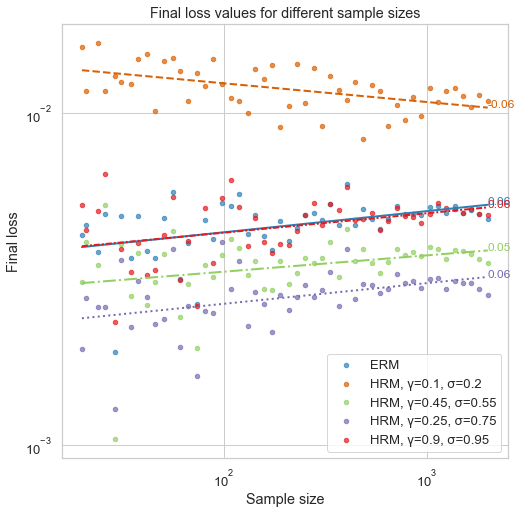

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams["figure.figsize"] = [8, 8]
np.random.seed(42)

def simulate_results(sample_sizes, feature_sizes, gamma_sigma_pairs, flags):
    final_losses_sample_size = []

    for n_samples in sample_sizes:
        for n_features in feature_sizes:
            X, Y = generate_linear_regression_dataset(n_samples, n_features, noise_std)

            for flag in flags:
                if flag == 0:
                    theta_optimized, loss_history = optimize_theta(X, Y, learning_rate, n_iterations, flag)
                    final_losses_sample_size.append((n_samples, loss_history[-1], flag))
                else:
                    for gamma, sigma in gamma_sigma_pairs:
                        theta_optimized, loss_history = optimize_theta(X, Y, learning_rate, n_iterations, flag, gamma, sigma)
                        final_losses_sample_size.append((n_samples, loss_history[-1], flag, gamma, sigma))

    return final_losses_sample_size

def plot_results(final_losses_sample_size, sample_sizes):
    colors = ['#2c7fb8', '#d95f02', '#91cf60', '#756bb1', '#e31a1c']
    linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
    labels_added = set()
    line_data = {color: [] for color in colors}

    for loss_info in final_losses_sample_size:
        label = "ERM" if loss_info[2] == 0 else "HRM"
        if len(loss_info) > 3:
            label += f", γ={loss_info[3]}, σ={loss_info[4]}"
            color_index = gamma_sigma_pairs.index((loss_info[3], loss_info[4])) + 1
        else:
            color_index = 0

        if label not in labels_added:
            plt.scatter(loss_info[0], loss_info[1], c=colors[color_index], label=label, s=20, alpha=0.7)
            labels_added.add(label)
        else:
            plt.scatter(loss_info[0], loss_info[1], c=colors[color_index], s=20, alpha=0.7)

        line_data[colors[color_index]].append((loss_info[0], loss_info[1]))

    for color, data_points in line_data.items():
        if data_points:
            x_vals, y_vals = zip(*data_points)
            line_coefficients = np.polyfit(np.log(x_vals), np.log(y_vals), 1)
            line_function = np.poly1d(line_coefficients)
            linestyle = linestyles[colors.index(color)]
            plt.plot(sample_sizes, np.exp(line_function(np.log(sample_sizes))), c=color, linestyle=linestyle, linewidth=2)
            plt.text(sample_sizes[-1], np.exp(line_function(np.log(sample_sizes[-1]))), f"{line_coefficients[0]:.2f}", color=color, fontsize=12)

    plt.xscale("log")
    plt.yscale("log")
    plt.title("Final loss values for different sample sizes")
    plt.xlabel("Sample size")
    plt.ylabel("Final loss")
    plt.legend()
    plt.show()


# Parameters for simulations
sample_sizes = np.logspace(np.log10(20), np.log10(2000), num=50).astype(int)
feature_sizes = [5]
gamma_sigma_pairs = [(0.1, 0.2), (0.45, 0.55), (0.25, 0.75), (0.9, 0.95)]
flags = [0, 1]

final_losses_sample_size = simulate_results(sample_sizes, feature_sizes, gamma_sigma_pairs, flags)
plot_results(final_losses_sample_size, sample_sizes)


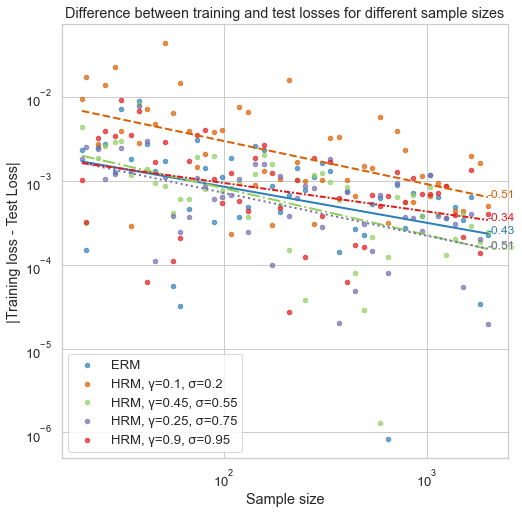

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams["figure.figsize"] = [8, 8]
np.random.seed(42)

def simulate_results(sample_sizes, feature_sizes, gamma_sigma_pairs, flags):
    final_losses_sample_size = []

    for n_samples in sample_sizes:
        for n_features in feature_sizes:
            X, Y = generate_linear_regression_dataset(n_samples, n_features, noise_std)

            # Split the dataset into training and testing sets
            train_ratio = 0.8
            train_size = int(n_samples * train_ratio)
            X_train, X_test = X[:train_size], X[train_size:]
            Y_train, Y_test = Y[:train_size], Y[train_size:]

            for flag in flags:
                if flag == 0:
                    theta_optimized, _ = optimize_theta(X_train, Y_train, learning_rate, n_iterations, flag)
                    train_loss = ERM_loss(theta_optimized, X_train, Y_train)
                    test_loss = ERM_loss(theta_optimized, X_test, Y_test)
                    final_losses_sample_size.append((n_samples, np.abs(train_loss - test_loss), flag))
                else:
                    for gamma, sigma in gamma_sigma_pairs:
                        theta_optimized, _ = optimize_theta(X_train, Y_train, learning_rate, n_iterations, flag, gamma, sigma)
                        train_loss = HRM_loss(theta_optimized, X_train, Y_train, gamma, sigma)
                        test_loss = HRM_loss(theta_optimized, X_test, Y_test, gamma, sigma)
                        final_losses_sample_size.append((n_samples, np.abs(train_loss - test_loss), flag, gamma, sigma))

    return final_losses_sample_size

def plot_results(final_losses_sample_size, sample_sizes):
    colors = ['#2c7fb8', '#d95f02', '#91cf60', '#756bb1', '#e31a1c']
    linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
    labels_added = set()
    line_data = {color: [] for color in colors}

    for loss_info in final_losses_sample_size:
        label = "ERM" if loss_info[2] == 0 else "HRM"
        if len(loss_info) > 3:
            label += f", γ={loss_info[3]}, σ={loss_info[4]}"
            color_index = gamma_sigma_pairs.index((loss_info[3], loss_info[4])) + 1
        else:
            color_index = 0

        if label not in labels_added:
            plt.scatter(loss_info[0], loss_info[1], c=colors[color_index], label=label, s=20, alpha=0.7)
            labels_added.add(label)
        else:
            plt.scatter(loss_info[0], loss_info[1], c=colors[color_index], s=20, alpha=0.7)

        line_data[colors[color_index]].append((loss_info[0], loss_info[1]))

    for color, data_points in line_data.items():
        if data_points:
            x_vals, y_vals = zip(*data_points)
            line_coefficients = np.polyfit(np.log(x_vals), np.log(y_vals), 1)
            line_function = np.poly1d(line_coefficients)
            linestyle = linestyles[colors.index(color)]
            plt.plot(sample_sizes, np.exp(line_function(np.log(sample_sizes))), c=color, linestyle=linestyle, linewidth=2)
            plt.text(sample_sizes[-1], np.exp(line_function(np.log(sample_sizes[-1]))), f"{line_coefficients[0]:.2f}", color=color, fontsize=12)

    plt.xscale("log")
    plt.yscale("log")
    plt.title("Difference between training and test losses for different sample sizes")
    plt.xlabel("Sample size")
    plt.ylabel("|Training loss - Test Loss|")
    plt.legend()
    plt.show()


# Parameters for simulations
sample_sizes = np.logspace(np.log10(20), np.log10(2000), num=50).astype(int)
feature_sizes = [5]
gamma_sigma_pairs = [(0.1, 0.2), (0.45, 0.55), (0.25, 0.75), (0.9, 0.95)]
flags = [0, 1]

final_losses_sample_size = simulate_results(sample_sizes, feature_sizes, gamma_sigma_pairs, flags)
plot_results(final_losses_sample_size, sample_sizes)


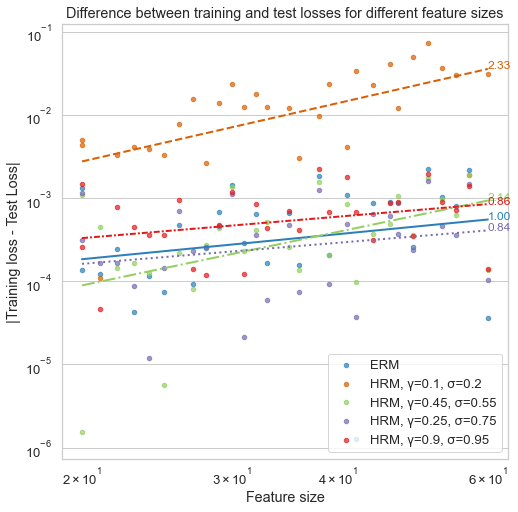

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams["figure.figsize"] = [8, 8]
np.random.seed(42)

def simulate_results_features(sample_sizes, feature_sizes, gamma_sigma_pairs, flags):
    final_losses_feature_size = []

    for n_samples in sample_sizes:
        for n_features in feature_sizes:
            X, Y = generate_linear_regression_dataset(n_samples, n_features, noise_std)

            # Split the dataset into training and testing sets
            train_ratio = 0.8
            train_size = int(n_samples * train_ratio)
            X_train, X_test = X[:train_size], X[train_size:]
            Y_train, Y_test = Y[:train_size], Y[train_size:]

            for flag in flags:
                if flag == 0:
                    theta_optimized, _ = optimize_theta(X_train, Y_train, learning_rate, n_iterations, flag)
                    train_loss = ERM_loss(theta_optimized, X_train, Y_train)
                    test_loss = ERM_loss(theta_optimized, X_test, Y_test)
                    final_losses_feature_size.append((n_features, np.abs(train_loss - test_loss), flag))
                else:
                    for gamma, sigma in gamma_sigma_pairs:
                        theta_optimized, _ = optimize_theta(X_train, Y_train, learning_rate, n_iterations, flag, gamma, sigma)
                        train_loss = HRM_loss(theta_optimized, X_train, Y_train, gamma, sigma)
                        test_loss = HRM_loss(theta_optimized, X_test, Y_test, gamma, sigma)
                        final_losses_feature_size.append((n_features, np.abs(train_loss - test_loss), flag, gamma, sigma))

    return final_losses_feature_size

def plot_results(final_losses_sample_size, sample_sizes):
    colors = ['#2c7fb8', '#d95f02', '#91cf60', '#756bb1', '#e31a1c']
    linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
    labels_added = set()
    line_data = {color: [] for color in colors}

    for loss_info in final_losses_sample_size:
        label = "ERM" if loss_info[2] == 0 else "HRM"
        if len(loss_info) > 3:
            label += f", γ={loss_info[3]}, σ={loss_info[4]}"
            color_index = gamma_sigma_pairs.index((loss_info[3], loss_info[4])) + 1
        else:
            color_index = 0

        if label not in labels_added:
            plt.scatter(loss_info[0], loss_info[1], c=colors[color_index], label=label, s=20, alpha=0.7)
            labels_added.add(label)
        else:
            plt.scatter(loss_info[0], loss_info[1], c=colors[color_index], s=20, alpha=0.7)

        line_data[colors[color_index]].append((loss_info[0], loss_info[1]))

    for color, data_points in line_data.items():
        if data_points:
            x_vals, y_vals = zip(*data_points)
            line_coefficients = np.polyfit(np.log(x_vals), np.log(y_vals), 1)
            line_function = np.poly1d(line_coefficients)
            linestyle = linestyles[colors.index(color)]
            plt.plot(sample_sizes, np.exp(line_function(np.log(sample_sizes))), c=color, linestyle=linestyle, linewidth=2)
            plt.text(sample_sizes[-1], np.exp(line_function(np.log(sample_sizes[-1]))), f"{line_coefficients[0]:.2f}", color=color, fontsize=12)

    plt.xscale("log")
    plt.yscale("log")
    plt.title("Difference between training and test losses for different feature sizes")
    plt.xlabel("Feature size")
    plt.ylabel("|Training loss - Test Loss|")
    plt.legend()
    plt.show()


# Parameters for simulations
sample_sizes = [1000]
feature_sizes = np.logspace(np.log10(20), np.log10(60), num=30).astype(int)
gamma_sigma_pairs = [(0.1, 0.2), (0.45, 0.55), (0.25, 0.75), (0.9, 0.95)]
flags = [0, 1]

final_losses_sample_size = simulate_results_features(sample_sizes, feature_sizes, gamma_sigma_pairs, flags)
plot_results(final_losses_sample_size, feature_sizes)